In [128]:
import re
import string
import unicodedata

import numpy as np
import seaborn as sns
import pandas as pd

import mplcairo
import matplotlib as mpl

mpl.use("module://mplcairo.qt")
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from bs4 import BeautifulSoup

from matplotlib.font_manager import FontProperties
import matplotlib.ticker as ticker

from klpt.preprocess import Preprocess
from klpt.tokenize import Tokenize
from klpt.stem import Stem

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    plot_confusion_matrix,
)

from sklearn.linear_model import LogisticRegression


%matplotlib inline
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [129]:
df = pd.read_csv("IMDB_Sorani_Reviews.csv")
df.head()

,review,sentiment
0,ئەم فیلمەم لە پۆلێکی ئایین بەکارهێنا کە فێری د...,1
1,"ئەم فیلمە بچووکە لە مێژ بوو لە لیستی ""پارێزەر""...",1
2,دووبارە سڵاو لە تاریکی. ماری هێرۆن بە تەواوی ل...,1
3,خاڵی کون، هەرچەندە لە شوێنەکاندا چەقبەستووە، ب...,1
4,باشە، نەمدەزانی چاوەڕوانی چی بکەم کاتێک بەرگەک...,1


<IPython.core.display.Javascript object>

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


<IPython.core.display.Javascript object>

In [103]:
df["review"].describe()

count                                                 50000
unique                                                49595
top       نمایشی ئەمڕۆم خۆشویست!!! جۆراوجۆر بوو و تەنها ...
freq                                                      5
Name: review, dtype: object

<IPython.core.display.Javascript object>

In [104]:
null_values = df.isnull().sum()
null_values

review       0
sentiment    0
dtype: int64

<IPython.core.display.Javascript object>

In [105]:
num_duplicates = df.duplicated().sum()
num_duplicates

405

<IPython.core.display.Javascript object>

In [106]:
# showing the duplicates
review = df["review"]
duplicated_review = df[review.isin(review[review.duplicated()])].sort_values("review")
duplicated_review.head()

,review,sentiment
40009,"""Go Fish"" ڕۆز ترۆچی بە ڕاست یان بە هەڵە ناوبان...",0
38257,"""Go Fish"" ڕۆز ترۆچی بە ڕاست یان بە هەڵە ناوبان...",0
22000,"""Les isNoveErs"" ڕەسەنی ڕەسەن و پێکەنیناوی و سە...",0
15237,"""Les isNoveErs"" ڕەسەنی ڕەسەن و پێکەنیناوی و سە...",0
45409,"""Witchery"" ڕەنگە تەنها ناتەباترین و بە شێوەیەک...",0


<IPython.core.display.Javascript object>

In [107]:
df.drop_duplicates(inplace=True)

<IPython.core.display.Javascript object>

In [108]:
print(f"The dataset contains {df.shape[0]} rows after removing duplicates")

The dataset contains 49595 rows after removing duplicates


<IPython.core.display.Javascript object>

In [109]:
preprocessor_ckb = Preprocess("Sorani", "Arabic", numeral="Latin")
tokenizer_ckb = Tokenize("Sorani", "Arabic")
stemmer = Stem("Sorani", "Arabic")

# function to clean data
def clean_text(text, lemmatize=False, english_char=True, english_num=False):
    soup = BeautifulSoup(text, "html.parser")  # remove html tags
    text = soup.get_text()
    emoji_clean = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    text = emoji_clean.sub(r"", text)
    text = re.sub(r"\.(?=\S)", ". ", text)  # add space after full stop
    text = re.sub(r"http\S+", "", text)  # remove urls
    punctuations = re.compile(
        rf"[{string.punctuation}\u060c\u060d\u061b\u061f\u00bb\u00ab\u06D6-\u06ED\u005c]+"
    )
    text = re.sub(punctuations, r"\n", text)  # remove punctuation
    # tokens = re.split('\W+', text) #create tokens
    if lemmatize:
        text = " ".join(
            [
                stemmer.lemmatize(word)
                for word in tokenizer_ckb.word_tokenize(word)
                if word not in preprocessor_ckb.stopwords
            ]
        )  # lemmatize
    else:
        text = " ".join(
            [word for word in text.split() if word not in preprocessor_ckb.stopwords]
        )
    if english_char:
        #         characters = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
        table = str.maketrans({key: None for key in string.ascii_letters})
        text = text.translate(table)

    if english_num:
        #         numbers = "1234567890"
        table = str.maketrans({key: None for key in string.digits})
        text = text.translate(table)
    return text

<IPython.core.display.Javascript object>

In [110]:
df["review"].iloc[2]

'دووبارە سڵاو لە تاریکی. ماری هێرۆن بە تەواوی لیستی فیلمەکان کۆدەکاتەوە کە وردەکارییەک لە سەردەمی تایبەتی خۆیاندا دەخاتە ڕوو. "من ئاندی وارهۆڵم گرت" و "سایکۆی ئەمریکی" لە باشترین حاڵەتدا بوو کاتێک کۆمێنتیان لەسەر قسە و باسەکانی کۆمەڵگا دەکرد لەو ماوەیەدا. هەرچەندە "پەیجی بێتی بەدناو" دیارە دەربارەی خاتوو پەیجە، بەڵام هەموو شتێک بەقەد لوتکەیەک لە پشت پەردەوە لە جیهانی وێنەگرتنی کینکی لە ساڵانی 50.<br /><br />بینینی فیلمەکە خۆشە چ لە ڕوانگەی چیرۆکەوە و چ لە ڕووی تەکنیکی شێوازی وێنەگرتن و پێکەوە دانانیەوە. فیلم و وێنەکانی B&W دانەوێڵەیی کات دەگرن و ناساندنی ڕەنگ لە میامی بیچ لە ڕێگەی وێنەکانی Bunny Yeager زۆر باشە. ڕۆڵی مۆرۆ)، کریس باوەر (وەک ئیرڤینگ کلاو) و لیلی تایلۆر. ئەستێرەی فیلمەکە ئەو مۆلی گرێچنە کە بەهرەمەند و کەمتەرخەم و کەمتەرخەمن و کەمتەرخەمن. خاتوو مۆڵ هەمیشە لێوار و ڕۆحێک دەهێنێتە ناو ڕۆڵەکانیەوە. ئەو بە تەواوی سەرسامکەر بوو لەو کەم بینرا، جەیسۆن ئەلێکساندەر دەرهێنەری فیلمی "تەنها سەیرکردن" بوو لە ساڵی ٢٠٠٠. زەردەخەنەکەی سەرنجڕاکێشە و جەستەی بێ کەموکوڕییە. بەڕاستی پێدەچێت ئەو

<IPython.core.display.Javascript object>

In [111]:
df["review"] = df["review"].apply(preprocessor_ckb.preprocess)
df["review"] = df["review"].apply(clean_text, lemmatize=False)

/usr/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


<IPython.core.display.Javascript object>

In [112]:
df["review"].iloc[2]

'دووبارە سڵاو تاریکی ماری هێرۆن لیستی فیلمەکان کۆدەکاتەوە وردەکارییەک سەردەمی تایبەتی خۆیاندا دەخاتە ئاندی وارهۆڵم گرت سایکۆی ئەمریکی حاڵەتدا کۆمێنتیان قسە باسەکانی کۆمەڵگا دەکرد ماوەیەدا هەرچەندە پەیجی بێتی بەدناو دیارە خاتوو پەیجە شتێک بەقەد لوتکەیەک پشت پەردەوە جیهانی وێنەگرتنی کینکی ساڵانی 50 بینینی فیلمەکە خۆشە چ ڕوانگەی چیرۆکەوە چ تەکنیکی شێوازی وێنەگرتن پێکەوە دانانیەوە فیلم وێنەکانی   دانەوێڵەیی کات دەگرن ناساندنی ڕەنگ میامی بیچ ڕێگەی وێنەکانی   باشە ڕۆڵی مۆرۆ کریس باوەر ئیرڤینگ کلاو لیلی تایلۆر ئەستێرەی فیلمەکە مۆلی گرێچنە بەهرەمەند کەمتەرخەم کەمتەرخەمن کەمتەرخەمن خاتوو مۆڵ هەمیشە لێوار ڕۆحێک دەهێنێتە ڕۆڵەکانیەوە سەرسامکەر بینرا جەیسۆن ئەلێکساندەر دەرهێنەری فیلمی سەیرکردن ساڵی 2000 زەردەخەنەکەی سەرنجڕاکێشە جەستەی کەموکوڕییە بەڕاستی پێدەچێت چێژ ڕۆڵە وەربگرێت یارمەتیدەرمان لەوە تێبگەین چۆن کچەی تەنیشتەوە تێنسیەوە دەتوانێت ببێتە شاژنی پین ئاپی جیهانی ژێرزەوی مرۆڤ چاوەڕێی تراکی دەنگی سەردەمەکە نایاب سەرنجڕاکێشە پاتسی کلاین پێگی لی دوو ئەکتەرە دیارەکانن هەرچەندە فیلمەکە ئاماژەیە دا

<IPython.core.display.Javascript object>

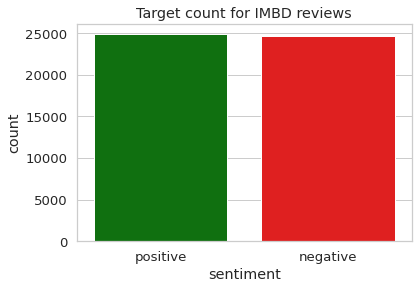

<IPython.core.display.Javascript object>

In [113]:
### Count Plot
sns.set(style="whitegrid", font_scale=1.2)
sns.countplot(x=df.sentiment, palette=["green", "red"], order=[1, 0])
plt.xticks(ticks=np.arange(2), labels=["positive", "negative"])
plt.title("Target count for IMBD reviews")
plt.show()

In [114]:
print(
    "Positive reviews are",
    (round(df["sentiment"].value_counts()[0])),
    "i.e.",
    round(df["sentiment"].value_counts()[0] / len(df) * 100, 2),
    "% of the dataset",
)
print(
    "Negative reviews are",
    (round(df["sentiment"].value_counts()[1])),
    "i.e.",
    round(df["sentiment"].value_counts()[1] / len(df) * 100, 2),
    "% of the dataset",
)

Positive reviews are 24710 i.e. 49.82 % of the dataset
Negative reviews are 24885 i.e. 50.18 % of the dataset


<IPython.core.display.Javascript object>

In [115]:
font_file = "/home/razhan/.local/share/fonts/KHejar.ttf"

<IPython.core.display.Javascript object>

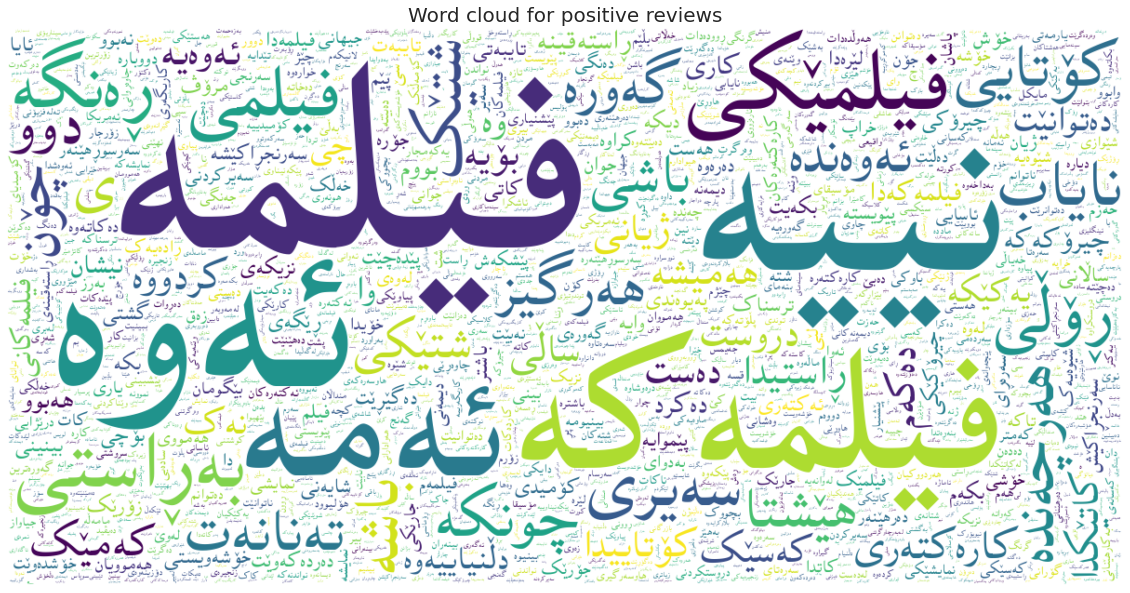

<IPython.core.display.Javascript object>

In [116]:
positive_data = df[df.sentiment == 1]['review']
positive_data_string = ' '.join(positive_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600, collocations = False, background_color="white", font_path=font_file).generate(positive_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for positive reviews',fontsize = 20)
plt.show()


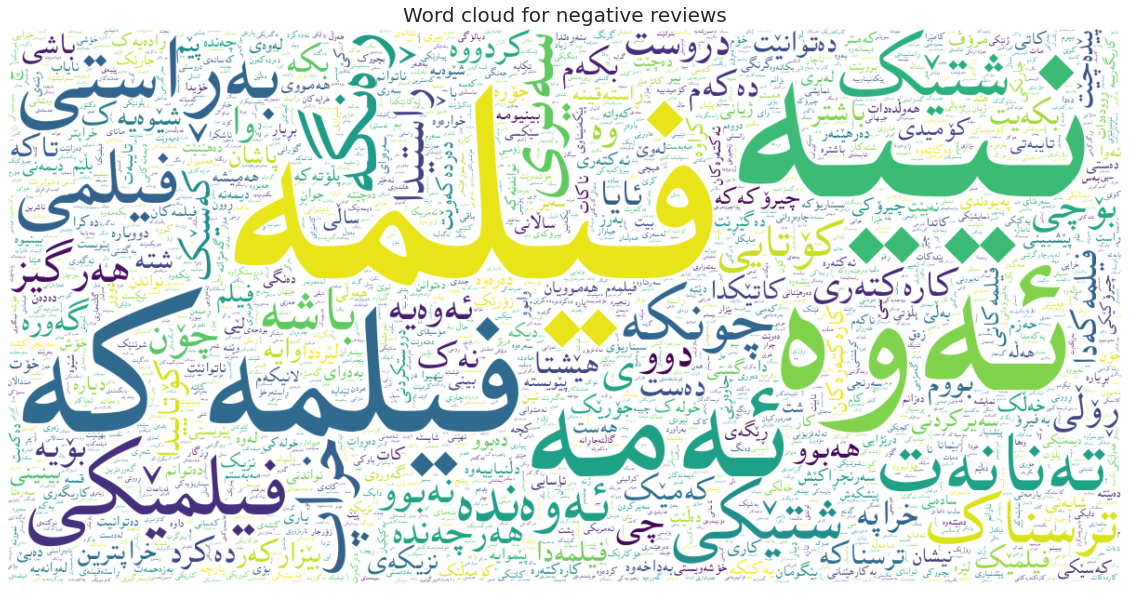

<IPython.core.display.Javascript object>

In [117]:
# word cloud for negative reviews
negative_data = df[df.sentiment == 0]["review"]
negative_data_string = " ".join(negative_data)
plt.figure(figsize=(20, 20))
wc = WordCloud(
    max_words=2000,
    width=1200,
    height=600,
    collocations=False,
    background_color="white",
    font_path=font_file,
).generate(negative_data_string)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word cloud for negative reviews", fontsize=20)
plt.show()

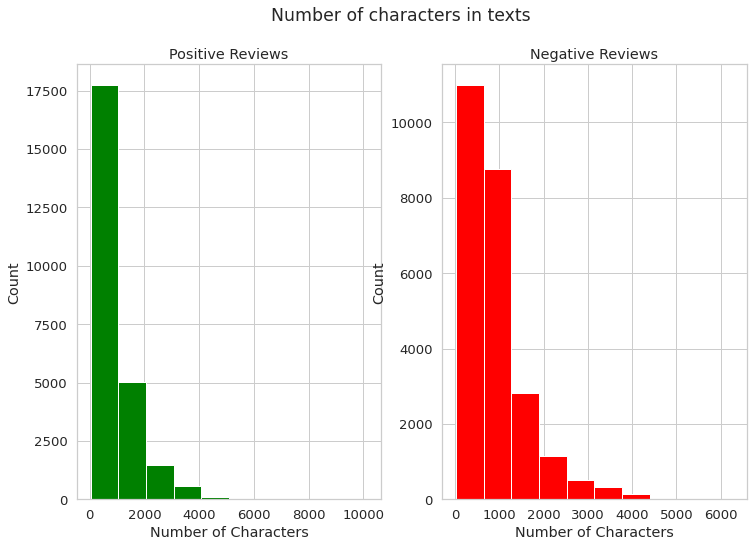

<IPython.core.display.Javascript object>

In [118]:
fig,(ax1,ax2) =plt.subplots(1,2,figsize=(12,8))
text_len=positive_data.str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Count')
text_len=negative_data.str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Count')
fig.suptitle('Number of characters in texts')
plt.show()



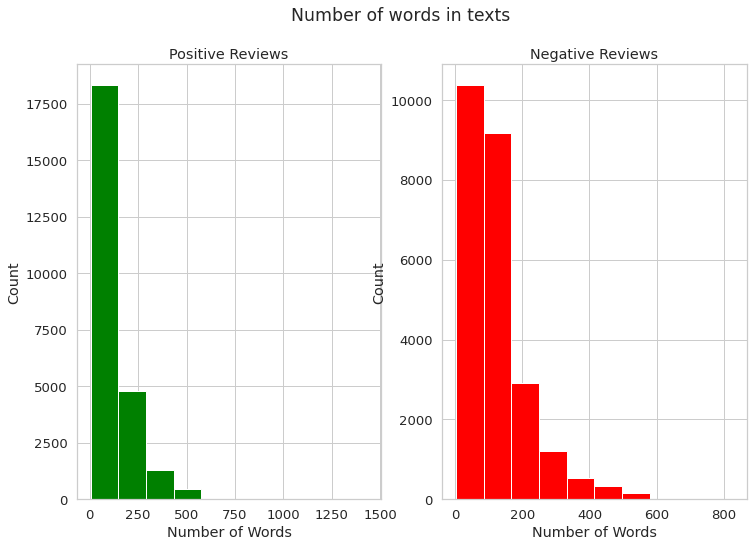

<IPython.core.display.Javascript object>

In [119]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

text_len = positive_data.str.split().map(lambda x: len(x))
ax1.hist(text_len, color="green")
ax1.set_title("Positive Reviews")
ax1.set_xlabel("Number of Words")
ax1.set_ylabel("Count")
text_len = negative_data.str.split().map(lambda x: len(x))
ax2.hist(text_len, color="red")
ax2.set_title("Negative Reviews")
ax2.set_xlabel("Number of Words")
ax2.set_ylabel("Count")
fig.suptitle("Number of words in texts")
plt.show()

/home/razhan/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/razhan/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


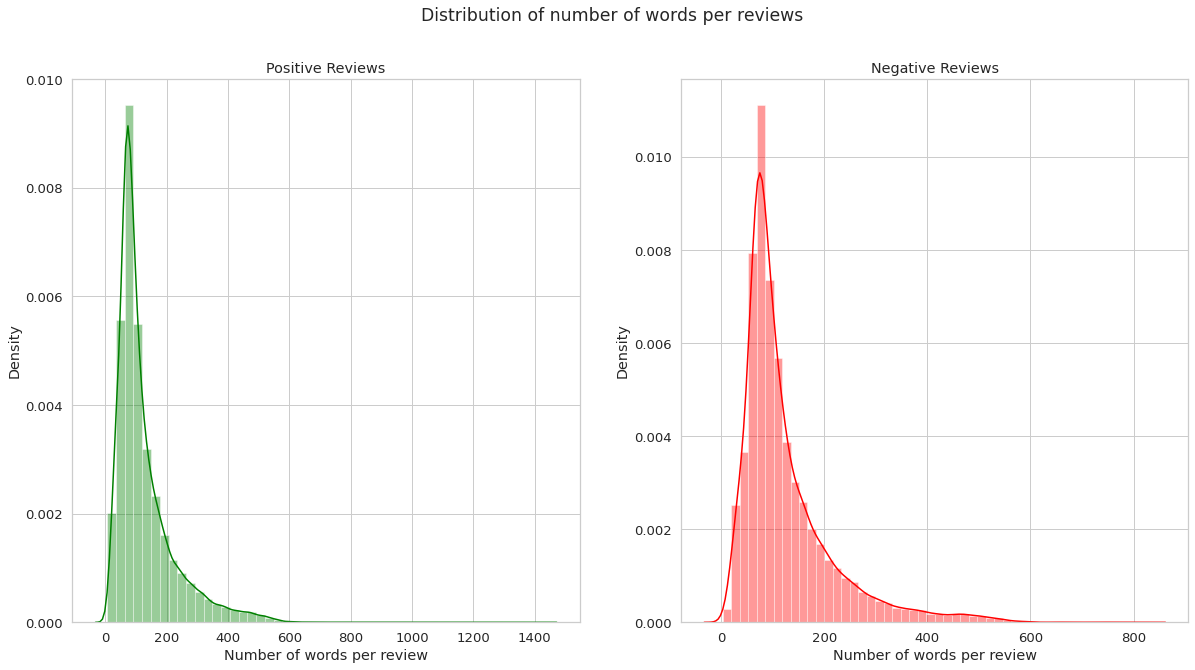

<IPython.core.display.Javascript object>

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
word = positive_data.str.split().apply(lambda x: len(x))
sns.distplot(word, ax=ax1, color="green")
ax1.set_title("Positive Reviews")
ax1.set_xlabel("Number of words per review")
word = negative_data.str.split().apply(lambda x: len(x))
sns.distplot(word, ax=ax2, color="red")
ax2.set_title("Negative Reviews")
ax2.set_xlabel("Number of words per review")
fig.suptitle("Distribution of number of words per reviews")
plt.show()

/home/razhan/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/razhan/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


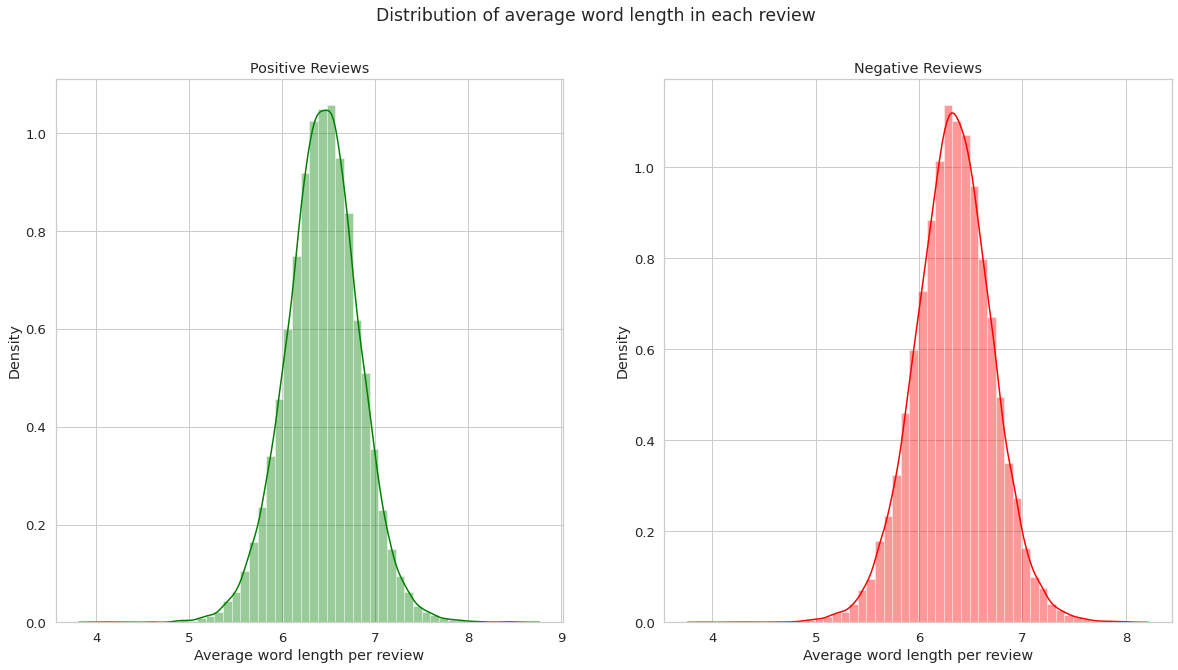

<IPython.core.display.Javascript object>

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
word = positive_data.str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1, color="green")
ax1.set_title("Positive Reviews")
ax1.set_xlabel("Average word length per review")
word = negative_data.str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax2, color="red")
ax2.set_title("Negative Reviews")
ax2.set_xlabel("Average word length per review")
fig.suptitle("Distribution of average word length in each review")
plt.show()

In [24]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words


corpus = get_corpus(df.review)
corpus[:5]

['فیلمەم', 'پۆلێکی', 'ئایین', 'بەکارهێنا', 'فێری']

<IPython.core.display.Javascript object>

In [25]:
from collections import Counter

counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common, columns=["corpus", "countv"])
most_common

,corpus,countv
0,فیلمە,54346
1,نییە,46286
2,ئەوە,42362
3,فیلمەکە,35703
4,ئەمە,33524
5,فیلمێکی,26699
6,بەڕاستی,26418
7,فیلمی,22161
8,ڕەنگە,21502
9,تەنانەت,20606


<IPython.core.display.Javascript object>

In [125]:
# splitting into train and test
train, test = train_test_split(df, test_size=0.2, random_state=42)
# train dataset
Xtrain, ytrain = train["review"], train["sentiment"]
# test dataset
Xtest, ytest = test["review"], test["sentiment"]

print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)

(39676,) (39676,)
(9919,) (9919,)


<IPython.core.display.Javascript object>

In [126]:
tfidf_vect = TfidfVectorizer()  # tfidfVectorizer
Xtrain_tfidf = tfidf_vect.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vect.transform(Xtest)

<IPython.core.display.Javascript object>

In [127]:
lr = LogisticRegression(C=0.1)
lr.fit(Xtrain_tfidf, ytrain)

LogisticRegression(C=0.1)

<IPython.core.display.Javascript object>

In [130]:
predictions = lr.predict(Xtest_tfidf)
print("Classification Report:")
print(classification_report(ytest, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4847
           1       0.85      0.88      0.86      5072

    accuracy                           0.86      9919
   macro avg       0.86      0.86      0.86      9919
weighted avg       0.86      0.86      0.86      9919



<IPython.core.display.Javascript object>

/home/razhan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


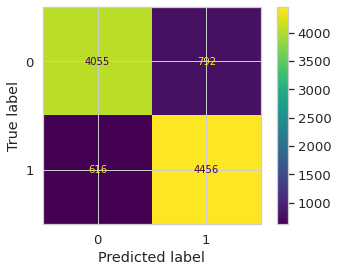

<IPython.core.display.Javascript object>

In [131]:
plot_confusion_matrix(lr, Xtest_tfidf, ytest)

In [132]:
def predict_sentiment(text_lst: list[str]):
    vectorized_data = tfidf_vect.transform(text_lst)

    preds = lr.predict(vectorized_data)

    for text, label in zip(text_lst, preds):
        if label == 1:
            print(text, "- ئەرێنی\n")
        else:
            print(text, "- نەرێنی\n")

<IPython.core.display.Javascript object>

In [133]:
unseen_data = [
    "فیلمێکی نایاب بوو",
    "ڕووداوەکان زۆر خێرا ڕوویان دەدا، نەمتوانی چێژی لێببینم",
    "بێ تام بوو، هیچ فڕی بە یەکەوە نەبوو",
]

predict_sentiment(unseen_data)

فیلمێکی نایاب بوو - ئەرێنی

ڕووداوەکان زۆر خێرا ڕوویان دەدا، نەمتوانی چێژی لێببینم - ئەرێنی

بێ تام بوو، هیچ فڕی بە یەکەوە نەبوو - نەرێنی



<IPython.core.display.Javascript object>

# References
most of the eda are taken from below kernel:
- https://www.kaggle.com/code/madz2000/sentiment-analysis-cleaning-eda-bert-88-acc/notebook